In [834]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
import scipy
import skimage
from PIL import Image

In [835]:
def read_images(image_path):
    img = cv2.imread(image_path)
    img  = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return img

In [836]:
def read_images_color(image_path):
    img = cv2.imread(image_path)
    img = cv2.normalize(img.astype('float'), None, 0.0, 1.0, cv2.NORM_MINMAX)
    return img

In [837]:
def create_compute_shift(img):
    shift_detector = cv2.xfeatures2d.SIFT_create()
    kp, desc = shift_detector.detectAndCompute(img, None)
    return kp, desc

In [838]:
def get_distance(desc_l, desc_r, k_pts_l, k_pts_r, threshold):
    dist = scipy.spatial.distance.cdist(desc_l, desc_r, 'sqeuclidean')
    row, col = np.where(dist<threshold)
    point_l = np.array([k_pts_l[i].pt for i in row])
    point_r = np.array([k_pts_r[i].pt for i in col])
    combine_pts = np.hstack((point_l, point_r))
    return combine_pts

In [839]:
def residual_error(matching, homography):
    left_img_pts = matching[:,0:2]
    right_img_pts = matching[:,2:4]

    ones = np.ones((matching.shape[0],1))
    left_img_homoginous_coordinates = np.concatenate([left_img_pts, ones], axis=1)

    left_img_transformed = np.matmul(homography,left_img_homoginous_coordinates.T)

    left_img_transformed = left_img_transformed.T
    left_xy = left_img_transformed[:,0:2]
    left_z =  left_img_transformed[:,2].reshape(left_xy.shape[0],1)

    left_transformed_coordinates = left_xy / left_z

    error = np. linalg.norm(right_img_pts - left_transformed_coordinates, axis=1) ** 2

    return error



In [840]:
def compute_homography(matching_pts):
    temp = []
    for i in range(0, matching_pts.shape[0]):
        x1, y1 = matching_pts[i][0:2]
        x2, y2 = matching_pts[i][2:4]

        row_1 = [x1, y1, 1, 0, 0, 0, -x2*x1, -x2 * y1, -x2]
        row_2 = [0, 0, 0, x1, y1, 1, -y2*x1, -y2* y1, -y2]
        temp.append(row_1)
        temp.append(row_2)

    U, s, V = np.linalg.svd(np.array(temp))
    homography = V[len(V)-1]
    homography = homography.reshape(3,3)

    return homography


In [841]:
def wrap_image_in_one_coordinate(left_img, right_img, homography):

    p_transform = skimage.transform.ProjectiveTransform(homography)
    h, w, c = right_img.shape
    wrp = skimage.transform.warp

    corners = np.array([[0,0],[0,h],[w,0],[w,h]])
    print(p_transform, h, w)
    transformed_c =  p_transform(corners)

    set_corners = np.vstack((transformed_c,np.array([[0,0],[0,h],[w,0],[w,h]])))

    c_min = np.min(set_corners, axis=0)
    c_max = np.max(set_corners, axis=0)

    output_shape = np.ceil((c_max - c_min)[::-1])

    shift = skimage.transform.SimilarityTransform(translation=-c_min)

    left_img_cval_1 = wrp(left_img, shift.inverse , output_shape = output_shape, cval = -1)
    left_img_cval_0 = wrp(left_img, shift.inverse , output_shape = output_shape, cval = 0)

    right_img_cval_1 = wrp(right_img, (p_transform + shift).inverse , output_shape = output_shape, cval = -1)

    right_img_cval_0 = wrp(right_img, (p_transform + shift).inverse, output_shape = output_shape, cval = 0)

    overlap = (left_img_cval_1 != -1.0).astype(int) + (right_img_cval_1 != -1.0).astype(int)
    overlap += (overlap < 1).astype(int)

    combined_image = (left_img_cval_0+right_img_cval_0)/overlap

    image = np.asarray(Image.fromarray((combined_image * 255).astype(np.uint8), mode='RGB'))

    return image

In [842]:
def show_mathcing_points(img_left, img_right, pts):
    plane = np.empty((max(img_left.shape[0], img_right.shape[0]), img_left.shape[1]+ img_right.shape[1]), np.uint8)

    plane[:, :img_left.shape[1]] = left_img

    plane[:, img_left.shape[1]:(img_left.shape[1]+ img_right.shape[1])] = right_img

    plt.imshow(plane)
    plt.plot([pts[:,0],pts[:,2]+img_left.shape[1]], [pts[:,1],pts[:,3]])
    plt.show()

In [843]:
def ransac(img_left, img_right, matches, threshold, iterations):
    max_inline = 0
    homography_matrix =[]
    residual_avg = 0

    for i in range(0,iterations):

        sample_index = np.random.choice(range(0,matches.shape[0]), size=4, replace=False)
        sample = np.array([ matches[index,:] for index in sample_index])
        homography_un_normalized = compute_homography(sample)
        homography = homography_un_normalized/homography_un_normalized[2][2]

        error = residual_error(matches, homography)
        index = np.where(error<threshold)

        points_inliners = matches[index]

        num_inliners = len(index)
        if max_inline <= num_inliners:
            max_inline = num_inliners
            inliner_pts = points_inliners.copy()
            homography_matrix = homography.copy()
            residual_avg = sum(residual_error(points_inliners, homography))/num_inliners
    show_mathcing_points(img_left, img_right, inliner_pts)

    return homography_matrix


In [844]:
left_img = read_images('./images/left.jpg')
right_img = read_images('./images/right.jpg')
left_img_color = read_images_color('./images/left.jpg')
right_img_color = read_images_color('./images/right.jpg')
left_key_point, left_descriptor = create_compute_shift(left_img)
right_key_point, right_descriptor = create_compute_shift(right_img)

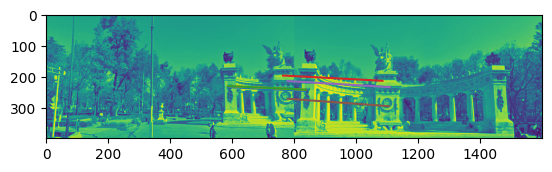

In [845]:
mathing_points = get_distance(left_descriptor, right_descriptor, left_key_point, right_key_point, 7000)

homography_matrix = ransac(left_img, right_img, mathing_points, 0.5, 9000)


In [846]:
img = wrap_image_in_one_coordinate(right_img_color,left_img_color, homography_matrix)

<ProjectiveTransform(matrix=
    [[ 8.72759945e-01,  5.08100590e-02, -4.97292318e+02],
     [-1.03628311e-01,  7.63876925e-01,  6.37236576e+01],
     [-5.59281663e-04,  2.93510026e-04,  1.00000000e+00]])> 398 800


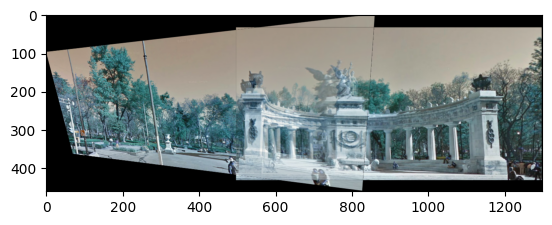

In [847]:
plt.imshow(img)

In [304]:
c = np.append(p[0][0:2],1)

In [305]:
c

array([0.77305372, 0.02719682, 1.        ])

In [306]:
p

array([[ 7.73053720e-01,  2.71968236e-02, -4.47590655e+02],
       [ 1.40223437e-01, -5.19298340e-01,  1.20339253e+02],
       [ 5.12574192e-04, -4.16116954e-03,  1.00000000e+00]])

In [307]:
p[0][0:2]

array([0.77305372, 0.02719682])

In [308]:
a, b = p[0][0:2]

In [309]:
a

0.7730537201811282

In [258]:
a = [1,2,3]
b = [4,2,3]
c = np.stack((a,b), axis=0)

In [268]:
c = np.stack((b,a,a), axis=0)

In [272]:
c = np.concatenate((c,a),axis=0)

ValueError: all the input arrays must have same number of dimensions, but the array at index 0 has 2 dimension(s) and the array at index 1 has 1 dimension(s)

In [458]:
a = np.ones((5,2))

In [459]:
b = np.ones((5,1)) * 2

In [460]:
c = a /b

In [461]:
c

array([[0.5, 0.5],
       [0.5, 0.5],
       [0.5, 0.5],
       [0.5, 0.5],
       [0.5, 0.5]])

In [421]:
x = d[0] *3

In [422]:
np.matmul(d,x)

array([6., 6.])

In [476]:
x = np.empty((2,3), np.uint8)

In [477]:
x

array([[1, 1, 1],
       [1, 1, 1]], dtype=uint8)